![arc-logo](admin/image/arc-logo.png)
# Projet P3
## MarketMachineLearningModel
Ce notebook contient les différentes étapes pour la réalisation de modèle de machine learning avec le jeu de données des tweets financiers.

`Auteur` : Romain Capocasale (INF3dlm-a)

`Superviseur` : Hatem Ghorbel

`Date` : 24.01.2020

# 1. Importation

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import math
import sys
import csv
import string

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.svm import SVR, LinearSVR, LinearSVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.manifold import TSNE
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import en_core_web_sm
import spacy
import pickle
from gensim.sklearn_api import D2VTransformer
from gensim.utils import simple_preprocess
from joblib import dump, load
import seaborn as sns
import random

# to make this notebook's output stable across runs
np.random.seed(42)

# 2. Chragement du jeu de données

In [2]:
dataset = pd.read_csv('dataset/market_dataset/market.csv')

# 3. Analyse du jeu de données

In [3]:
dataset.head()

,title,sentiment
0,putting apple's record-breaking quarter into c...,0.0
1,"""@wsj: apple plans to start shipping apple wat...",-1.0
2,nike has tested the $92 level 3 times this yea...,1.0
3,"""@howardlindzon: me too (long) @sexonthebeach:...",0.0
4,@3score66 $c,0.0


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1225718 entries, 0 to 1225717
Data columns (total 2 columns):
title        1225718 non-null object
sentiment    1225718 non-null float64
dtypes: float64(1), object(1)
memory usage: 18.7+ MB


In [5]:
dataset.describe()

,sentiment
count,1.225718e+06
mean,6.178567e-02
std,6.167171e-01
min,-1.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,3.333333e-01
max,1.000000e+00


Le jeu de données contient 2 colonnes :
    - sentiment : le sentiment de la pharse, -1 pour negatif et 1 pour positif
    - title : la phrase en question

## 3.1 Répartition des classes

In [6]:
nb_pos, nb_neg, nb_ntr = len([sent for sent in dataset.sentiment if sent > 0]), len([sent for sent in dataset.sentiment if sent < 0]), len([sent for sent in dataset.sentiment if sent == 0])
tot = len(dataset)
print("Number of data : {}".format(tot))
print("Number of positive data : {} ({}%)".format(nb_pos, round( nb_pos/tot*100, 3)))
print("Number of negative data : {} ({}%)".format(nb_neg, round( nb_neg/tot*100, 3)))
print("Number of neutral data : {} ({}%)".format(nb_ntr, round( nb_ntr/tot*100, 3)))
print("Ratio positive/negative : {}".format(round(nb_pos/nb_neg, 3)))

Number of data : 1225718
Number of positive data : 315852 (25.769%)
Number of negative data : 238591 (19.465%)
Number of neutral data : 671275 (54.766%)
Ratio positive/negative : 1.324


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BF912C35C8>]],
      dtype=object)

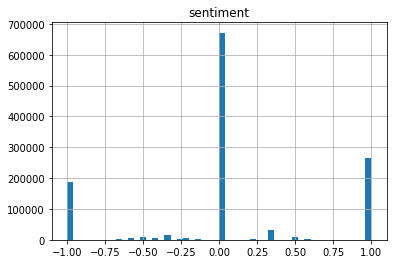

In [7]:
dataset.hist(bins=50)

On remarque qu'il y a beaucoup trop de phrases avec un setiment égal à 0. Sinon on remarque que les phrases sont en général sois totalement positive sois totalement néagative.

## 3.2 Nombre de mot moyen par phrase

In [8]:
def average_word_by_sentence(sentences):
    nb_total_word = 0
    for row in sentences:
        nb_total_word += len(row.split())
    return round(nb_total_word / len(sentences), 3)

In [9]:
print("Average of word by sentence : {}".format(average_word_by_sentence(dataset['title'])) )

Average of word by sentence : 13.487


Text(0, 0.5, 'Number of sentence')

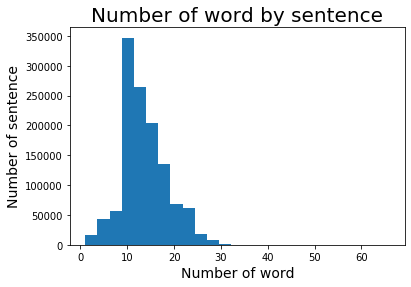

In [10]:
num_word_by_sentence = [len(x.split()) for x in dataset['title']]#count the number of word for each sentences

plt.hist(num_word_by_sentence, bins=25)
plt.title('Number of word by sentence', fontsize=20)
plt.xlabel('Number of word', fontsize=14)
plt.ylabel('Number of sentence', fontsize=14)

On remarque que la moyenne de nombre de mot par phrase est de **13** et on peut voir sur le graphe la répartirion du nombre de mot par phrase.

# 4. Reduction de la taille du jeu de données
* Suppresion de 3/4 des phrases qui ont une polarité de 0. Cela corresponds à un peu près 500'000 phrases
* On garde seulement 30'000 phrases sur les plus de 700'000 phrases restantes. Car sinon l'entrainement des modéles prends beaucoup trop de temps.

In [3]:
row_to_remove = []
for i, row in dataset.iterrows():
    if row['sentiment'] == 0:
        rand = random.randint(0,3)
        if  rand == 0 or rand == 1 or rand == 2:
            row_to_remove.append(i)

In [4]:
len(row_to_remove)

503395

In [5]:
dataset = dataset.drop(row_to_remove)

In [6]:
len(dataset)

722323

In [7]:
dataset = dataset[0:30000]

# 5. Séparation des observation et des étiquettes

In [8]:
X = dataset['title']
y = dataset['sentiment']

## 5.1 Séparation du jeu d'entrainement et jeu de test 
Le jeu d'entrainement est séparé en 2 parties, La première partie est le jeu d'entrainement qui sera utilisé pour la création du modèle d'analyse de sentiment. Le jeu de test sera lui utilisé pour tester la qualité des modèles évalués.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# 6. Definition des méthode de calcul de score
La méthode print_scores() permet de calculer la RMSE, la MAE et la précision à partir des vrai étiquettes et des étiquettes prédites. Il est également possible d'indiquer le seuil désiré, le seuil permet de definir pour une prédiction si elle doit considéré come positive ou négative. La méthode regression_score_to_classification() permet de transformer les étiquettes du format régression au format classification. Les étiquettes de -1 à seuil sont mise à 0 et celles de seuil à 1 sont mise à 1.

In [20]:
def remove_near_zero_values(y_test, y_pred, threshold):
    '''As the classifier is here binary, on only keep the values between -1 and 0 not included and between 1 and 0 not included. 
    You must therefore delete the values at zero.Put in a list the indices of the values which are 0 and remove them from the 2 lists.
        
    y_test -- list of real value
    y_pred -- list of predicted value
    thrshold -- seuil
    
    return -- a tuple which contain y_test and y_pred without 0 values
    '''
    index_to_remove = []
    i = 0
    for test, pred in zip(y_test, y_pred):
        if test == threshold or pred == threshold:
            index_to_remove.append(i)
        i+=1
    y_test = [i for j, i in enumerate(y_test) if j not in index_to_remove]
    y_pred = [i for j, i in enumerate(y_pred) if j not in index_to_remove]
    return (y_test, y_pred)

def regression_score_to_classification(labels, threshold, offset=0.1):
    '''Set to 0 regression prediction between -1 and thresold, set to 1 regression preiction between thresold and 1
    Allow to pass from regression prediction to classification prediction
    
    labels -- list of regression score
    thresold -- thresold
    
    return -- list of labels either 0 or 1
    '''
    
    y_clf = []
    for i, y in enumerate(labels):
        if y <= threshold:
            y_clf.append(0)
        elif y > threshold:
            y_clf.append(1)
    return np.array(y_clf)
        

def print_scores(name, y_test, y_pred, threshold=0, show_classification_report=False):
    '''Display the RMSE, MAE and accuracy for a model
    
    name -- name of the model
    y_test -- true data
    y_pred -- predicted data 
    threshold=0 -- threshold
    show_classification_report=False -- display the score with sklearn.metrics.classification_report function
    
    '''
    print("RMSE for {} : {}".format(name, np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
    print("MAE for {} : {}".format(name, metrics.mean_absolute_error(y_test, y_pred)))
    
    y_test, y_pred = remove_near_zero_values(y_test, y_pred, threshold)
    
    y_test_clf = regression_score_to_classification(y_test, threshold)
    y_pred_clf = regression_score_to_classification(y_pred, threshold)
    
    print("Accuracy for {} : {}".format(name, metrics.accuracy_score(y_test_clf, y_pred_clf)))
    print("Recall for {} : {}".format(name, metrics.recall_score(y_test_clf, y_pred_clf)))
    print("Precision for {} : {}".format(name, metrics.precision_score(y_test_clf, y_pred_clf)))
    if show_classification_report:
        print(metrics.classification_report(y_test_clf, y_pred_clf))

# 7. Score de textblob et VADER
Nous allons comparé le score de l'analyseur de sentiment de VADER(nltk) et textblob sur le jeu d'entrainement. Il est à noté que les phrases ne sont pas prétraité avant d'être envoyé aux analyseur de sentiment. En effet, ces 2 analyseur posséde leur propre méthode de prétraitement de texte. Les scores obtenus ici seront utilisé comme score de référence pour l'évaluation des futures modèles. Le but des futures modèles est de battre ces scores.

In [22]:
y_pred_textblob = []

for x in X_test:
    blob_analyser = TextBlob(x)
    y_pred_textblob.append(blob_analyser.polarity)
    
y_pred_textblob = np.array(y_pred_textblob)
print_scores('textblob', y_test, y_pred_textblob)

RMSE for textblob : 0.7814418121312904
MAE for textblob : 0.6545759489782979
Accuracy for textblob : 0.6775808936825886
Recall for textblob : 0.8589689857502095


In [23]:
vader_analyser = SentimentIntensityAnalyzer()

y_pred_vader = []
for x in X_test:
    y_pred_vader.append(vader_analyser.polarity_scores(x)['compound'])

y_pred_vader = np.array(y_pred_vader)
print_scores('VADER', y_test, y_pred_vader)

RMSE for VADER : 0.7365143067077652
MAE for VADER : 0.6033055264097015
Accuracy for VADER : 0.7878756476683938
Recall for VADER : 0.8894206118612203


On constate que la RMSE et la MAE des deux modèles est extrement élevé. Si les modèles ont une si bonne précision et rappel parqu'il prédise enormement de fois la polarité 0. Comme la polarité 0 est retiré de pour le calcul de la précision et du rappel, ceci explique ces bons résultats. Ces 2 analyseurs fournissent donc de mauvais résultats.

# 8. Traitement du texte
Utilisations de la librairie de Gensim pour le prétraitement, car elle est effectue le processus de manière très rapide.

In [11]:
X_train_pre_gen = [' '.join(simple_preprocess(sentence)) for sentence in X_train ]
X_test_pre_gen = [' '.join(simple_preprocess(sentence)) for sentence in X_test ]

# 9. Modèle de machine learning avec TFidf

## 9.1 Création des pipelines et entrainement des modeles
Un pipeline est créé pour chaque type de modèle. Trois types de modèles ont été selectionné : 

* la régression linéaire
* la machine à vecteur de support 
* la foret aléatoire

Les différents pipelines sont entrainés avec les données d'entrainements.

In [12]:
lr_model = Pipeline([('tfidf', TfidfVectorizer()),
                    ('lr', LinearRegression(n_jobs=-1))])

svr_model = Pipeline([('tfidf', TfidfVectorizer()),
                      ('svr', LinearSVR())])

rfr_model = Pipeline([('tfidf', TfidfVectorizer()),
                    ('rfr', RandomForestRegressor(n_jobs=-1))])

lr_model.fit(X_train_pre_gen, y_train)
print("lr_model is done")
svr_model.fit(X_train_pre_gen, y_train)
print("svr_model is done")
rfr_model.fit(X_train_pre_gen, y_train)
print("rfr_model is done")

lr_model is done


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


svr_model is done


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


rfr_model is done


## 9.2 Evaluation des modèles
On peut constater que pour la plupart des modèles la précision et le rappel ont de très bon score.

In [13]:
y_pred_lr = lr_model.predict(X_test_pre_gen)
print_scores('Linear regression', y_test, y_pred_lr)
print("\n")
y_pred_svr = svr_model.predict(X_test_pre_gen)
print_scores('Support Vector Regression', y_test, y_pred_svr)
print("\n")
y_pred_rfr = rfr_model.predict(X_test_pre_gen)
print_scores('Random forest regressor', y_test, y_pred_rfr)

RMSE for Linear regression : 1.0926329284922276
MAE for Linear regression : 0.5334656636305064
Accuracy for Linear regression : 0.8847533632286996
Recall for Linear regression : 0.8880471380471381
Precision for Linear regression : 0.8948261238337574


RMSE for Support Vector Regression : 0.3492736798282896
MAE for Support Vector Regression : 0.19696039627210665
Accuracy for Support Vector Regression : 0.9541106128550074
Recall for Support Vector Regression : 0.9739057239057239
Precision for Support Vector Regression : 0.9419267299864315


RMSE for Random forest regressor : 0.34571704047421387
MAE for Random forest regressor : 0.15408975228475233
Accuracy for Random forest regressor : 0.9354984894259819
Recall for Random forest regressor : 0.9529878221467006
Precision for Random forest regressor : 0.9280198565912852


## 9.4 Entrainement par validation croisée

In [15]:
scores = cross_val_score(rfr_model, X_train_pre_gen, y_train, scoring="neg_mean_absolute_error", cv=10, n_jobs=-1)
print(-scores)

[0.15397525 0.1606733  0.17495864 0.1553099  0.17603296 0.16743959
 0.15684131 0.15093928 0.15093962 0.1592801 ]


## 9.4 Sauvegarde du modèle

In [18]:
dump(rfr_model, 'saved_model/market_dataset_tfidf.joblib')

['saved_model/market_dataset_tfidf.joblib']

# 10. Modèle de machine learning avec w2v

## 10.1 Prétraitement du texte

In [16]:
X_train_pre_list = []
for sentence in X_train:
    X_train_pre_list.append(simple_preprocess(sentence))
    
X_test_pre_list = []
for sentence in X_test:
    X_test_pre_list.append(simple_preprocess(sentence))

## 10.2 Création du word2vec

In [17]:
doc2Vec_model =  D2VTransformer()
doc2Vec_model.fit(X_train_pre_list+X_test_pre_list)

D2VTransformer(alpha=0.025, batch_words=10000, cbow_mean=1, comment=None,
               dbow_words=0, dm=1, dm_concat=0, dm_mean=None, dm_tag_count=1,
               docvecs=None, docvecs_mapfile=None,
               hashfxn=<built-in function hash>, hs=0, iter=5,
               max_vocab_size=None, min_alpha=0.0001, min_count=5, negative=5,
               sample=0.001, seed=1, size=100, sorted_vocab=1, trim_rule=None,
               window=5, workers=3)

In [18]:
X_train_pre_d2v = doc2Vec_model.transform(X_train_pre_list)
X_test_pre_d2v = doc2Vec_model.transform(X_test_pre_list)

## 10.3 Création des pipelines et entrainement des modèles

In [19]:
rfr_model_d2v = RandomForestRegressor()
rfr_model_d2v.fit(X_train_pre_d2v, y_train)

lr_model_d2v = LinearRegression()
lr_model_d2v.fit(X_train_pre_d2v, y_train)

svr_model_d2v = LinearSVR()
svr_model_d2v.fit(X_train_pre_d2v, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

In [20]:
rfr_pipeline_d2v = Pipeline([('d2v', doc2Vec_model),
                     ('rfr', rfr_model_d2v)])

lr_pipeline_d2v = Pipeline([('d2v', doc2Vec_model),
                     ('rfr', lr_model_d2v)])

svr_pipeline_d2v = Pipeline([('d2v', doc2Vec_model),
                    ('svr', svr_model_d2v)])

## 10.4 Évaluation des modèles
On voit que les scores se dégrade fortement avec le word2vec.

In [21]:
y_pred_rfr_d2v = rfr_pipeline_d2v.predict(X_test_pre_list)
print_scores('Random forest regressor', y_test, y_pred_rfr_d2v)
print("\n")
y_pred_lr_d2v = lr_pipeline_d2v.predict(X_test_pre_list)
print_scores('Linear regression', y_test, y_pred_lr_d2v)
print("\n")
y_pred_svr_d2v = svr_pipeline_d2v.predict(X_test_pre_list)
print_scores('Support Vector Regression', y_test, y_pred_svr_d2v)

RMSE for Random forest regressor : 0.7552682779800307
MAE for Random forest regressor : 0.6356204922238256
Accuracy for Random forest regressor : 0.6457627118644068
Recall for Random forest regressor : 0.6883381924198251
Precision for Random forest regressor : 0.6574770258980785


RMSE for Linear regression : 0.7515256013403053
MAE for Linear regression : 0.6385075631691245
Accuracy for Linear regression : 0.6635779405171125
Recall for Linear regression : 0.7333709131905298
Precision for Linear regression : 0.665984131046839


RMSE for Support Vector Regression : 0.7565264383108383
MAE for Support Vector Regression : 0.6401830958063643
Accuracy for Support Vector Regression : 0.6516215812285159
Recall for Support Vector Regression : 0.7511273957158963
Precision for Support Vector Regression : 0.6479455385363482


## 10.5 Entrainement pas validation croisée

In [23]:
scores = cross_val_score(rfr_model, X_train_pre_gen, y_train, scoring="neg_mean_absolute_error", cv=10, n_jobs=-1)
print(-scores)

[0.15969199 0.15558303 0.16570083 0.14883897 0.17958089 0.17269955
 0.16909911 0.16064475 0.14690355 0.16338417]


## 10.6 Représentation T-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.062s...
[t-SNE] Computed neighbors for 10000 samples in 23.265s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.051819
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.583916
[t-SNE] KL divergence after 1000 iterations: 3.224224


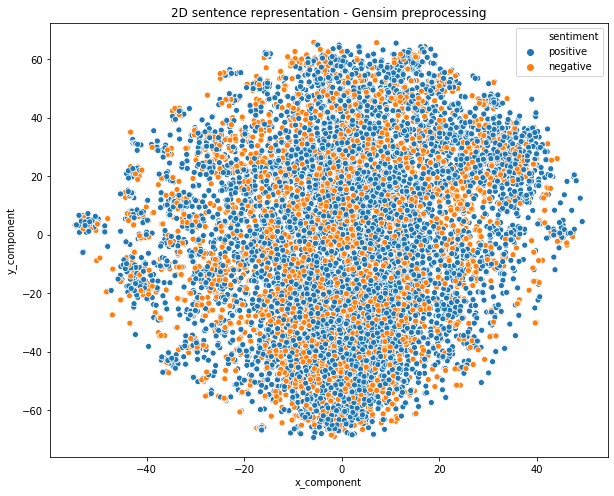

In [17]:
tsne = TSNE(n_components=2, random_state=0, verbose=1)
X_2d_gen = tsne.fit_transform(X_train_pre_d2v[0:10000])

X_component_gen = [item[0] for item in X_2d_gen]
Y_component_gen = [item[1] for item in X_2d_gen]

sent = ["positive" if sent>= 0 else "negative" for sent in (y_train.tolist()[0:10000])]

df_scatter_gen = pd.DataFrame({'x_component':X_component_gen, 'y_component':Y_component_gen, 'sentiment':sent})
plt.figure(figsize=(10,8))
plt.title("2D sentence representation - Gensim preprocessing")
ax = sns.scatterplot(x='x_component', y='y_component', hue='sentiment', data=df_scatter_gen)

# 10.6 Sauvegarde du modèle

In [25]:
dump(rfr_pipeline_d2v, 'saved_model/market_dataset_w2v.joblib')

['saved_model/market_dataset_w2v.joblib']

# 11. word2vec financier 
## 11.1 Importation du word2vec financier

In [32]:
sys.path.insert(0, 'word2vec/financialWord2vec/src')
from financial_corpus import FinancialCorpus
from financial_w2vec import FinancialWord2Vec

financial_w2vec = pickle.load(open('word2vec/financialWord2vec/data/models_pickle/FinancialWord2Vec.pkl','rb'))
financial_corpus = financial_w2vec.financial_corpus

bigram_mod = financial_corpus.bigram_mod
trigram_mod = financial_corpus.bigram_mod

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\romain.capocasa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 11.3 Longeur maximum d'une phrase

In [33]:
max_sentence_length = 0
for sentence in dataset["title"]:
    sentence_length = len(sentence.split())
    if sentence_length > max_sentence_length:
        max_sentence_length = sentence_length
print("The maximum word in a sentence is : {}".format(max_sentence_length))

The maximum word in a sentence is : 41


## 11.4 Calcul du Tf-idf
Le score TF-idf est calculé sur le jeu de donnée et les scores sont exporté dans un dictionnaire avec comme clé le mot et comme valeur le score TF-idf de ce mot.

In [34]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(X_train_pre_gen+X_test_pre_gen)

feature_names = tfidf.get_feature_names()
word2tfidf = dict(zip(feature_names, tfidf.idf_))

## 11.5 Définition des fonctions
Definitions des différentes fonctions permettant de représenter une phrase dans l'espace.

In [35]:
def get_tfidf_score(word):
    '''Return the TF-idf score for a word. If the word is not in the dict return 0.
    
    word -- a word of a sentence
    
    return -- the TF-idf score for this word
    '''
    if word in word2tfidf:
        return word2tfidf[word]
    else:
        return 0.0

In [36]:
def get_w2v_from_word(word, dimension=100):
    '''Return the word2vec vector for the given word. 
    If the word is not in the word2vec vocab return a fille vector of 0 the size of the dimension
    
    word -- a word of a sentence
    dimension -- the dimension of the vector
    
    return -- The word2vec vector
    '''
    if word in w2vec_model.wv.vocab: 
        doc = trigram_mod[bigram_mod[[word]]]
        return w2vec_model.wv[doc][0]
    else :
        return np.zeros(dimension)

In [37]:
def sentences_to_w2v_big_vector(sentences, mode, dimesion=100):
    '''Transforms the list of passed sentences into a vector representation. The vectors here are concatenate.
    For exemple : if the maximum sentence size is 25 and the dimension is 100. The number of vector component will be 2500.
    
    sentences -- list of preprocessed sentences
    mode -- type of vectorial representation, 'concat' => concatene all the word vector in sequence,'concat_tfidf' => concatene the word vector and multiply by the tf-idf score of the word, 
    dimension -- the dimension of the vector

    return -- the list of sentences in the space
    '''
    sentences_w2v = []
    for sentence in sentences:  
        
        vectors = np.asarray([])
        splited_sentence = sentence.split()
        for i in range(0, max_sentence_length):
            try :
                word = splited_sentence[i]
                w2v_word = get_w2v_from_word(word)
                
                if mode=="concat_tfidf":
                    tfidf_score = get_tfidf_score(word)
                    vectors = np.append(vectors, w2v_word*tfidf_score)
                elif mode=="concat":
                    vectors = np.append(vectors, w2v_word)
                
            except IndexError:
                vectors = np.append(vectors, np.zeros(dimension))
                
        sentences_w2v.append(vectors)
    return sentences_w2v

In [38]:
def sentences_to_w2v_small_vector(sentences, mode, dimension=100):
    '''Transforms the list of passed sentences into a vector representation. The vector is summed.
    For exemple : if the maximum sentence size is 25 and the dimension is 100. The number of vector component will be 100.
    
    sentences - list of preprocessed sentences
    mode -- type of vectorial representation, 'sum' => sum all the vector, 'sum_tfidf' => sum the vector and multiply each vector by tf_idf score, 'avg' => sum all the vector and divide by the sentence length, 'avg' => sum the vector, multiply each vector by tf_idf score and divide by sentence length
    dimension -- the dimension of the vector
    
    return the list of sentences in the space
    '''
    sentences_w2v = []    
    for sentence in sentences:
        vectors = np.zeros(100)
        
        splited_sentence = sentence.split()
        for word in splited_sentence:
            w2v_word = get_w2v_from_word(word)
            
            if mode=="sum_tfidf" or mode=="avg_tfidf":
                tfidf_score=get_tfidf_score(word)
                vectors = np.add(vectors, w2v_word*tfidf_score)
            elif mode=="sum" or mode=="avg":              
                vectors = np.add(vectors, w2v_word)
        
        if mode=="avg_tfidf" or mode=="avg":    
            if len(splited_sentence) != 0:
                sentences_w2v.append(vectors/len(splited_sentence))
            else :
                sentences_w2v.append(np.zeros(dimension))
        elif mode=="sum" or mode=="sum_tfidf":
            sentences_w2v.append(vectors)
    return np.asarray(sentences_w2v)

## 11.6 Représentation des phrases dans l'espace

In [39]:
X_train_pre_w2v = sentences_to_w2v_small_vector(X_train_pre_gen, mode="avg")
X_test_pre_w2v = sentences_to_w2v_small_vector(X_test_pre_gen, mode="avg")

## 11.7 Entrainement des modèles

In [40]:
rfr_model_w2v = RandomForestRegressor()
rfr_model_w2v.fit(X_train_pre_w2v, y_train)
print("training finish for rfr")

lr_model_w2v = LinearRegression()
lr_model_w2v.fit(X_train_pre_w2v, y_train)
print("training finish for lr")

svr_model_w2v = LinearSVR()
svr_model_w2v.fit(X_train_pre_w2v, y_train)
print("training finish for svr")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


training finish for rfr
training finish for lr


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


training finish for svr


## 10.8 Calcul des scores
On remarque cette fois ci que la précison et le rappel augmente par rapport à Gensim. Cependant, la rmse et la mae n'ont pas un bon scrore

In [33]:
y_pred_rfr_w2v = rfr_model_w2v.predict(X_test_pre_w2v)
print_scores('Random forest regressor', y_test, y_pred_rfr_w2v)
print("\n")
y_pred_lr_w2v = lr_model_w2v.predict(X_test_pre_w2v)
print_scores('Linear regression', y_test, y_pred_lr_w2v)
print("\n")
y_pred_svr_w2v = svr_model_w2v.predict(X_test_pre_w2v)
print_scores('Support Vector Regression', y_test, y_pred_svr_w2v)

RMSE for Random forest regressor : 0.5713135327697205
MAE for Random forest regressor : 0.42355800644806385
Accuracy for Random forest regressor : 0.8204118715929739
Recall for Random forest regressor : 0.8558378532686269
Precision for Random forest regressor : 0.8148953519978255


RMSE for Linear regression : 0.6316203480502239
MAE for Linear regression : 0.510548448504809
Accuracy for Linear regression : 0.7995815274248991
Recall for Linear regression : 0.8162344983089064
Precision for Linear regression : 0.8078103207810321


RMSE for Support Vector Regression : 0.6437559746566366
MAE for Support Vector Regression : 0.49696518798889894
Accuracy for Support Vector Regression : 0.7952473471827829
Recall for Support Vector Regression : 0.8173618940248027
Precision for Support Vector Regression : 0.800662617338487


## 11.9 Entrainement par validation croisée

In [38]:
scores = cross_val_score(rfr_model_w2v, X_train_pre_w2v, y_train, scoring="neg_mean_absolute_error", cv=10, n_jobs=-1)
print(-scores)

[0.42358149 0.42593333 0.41529725 0.42469223 0.43113329 0.42107856
 0.42723507 0.41865811 0.40699905 0.42215297]


## 11.9 T-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.062s...
[t-SNE] Computed neighbors for 10000 samples in 22.756s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.238922
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.218048
[t-SNE] KL divergence after 1000 iterations: 2.156854


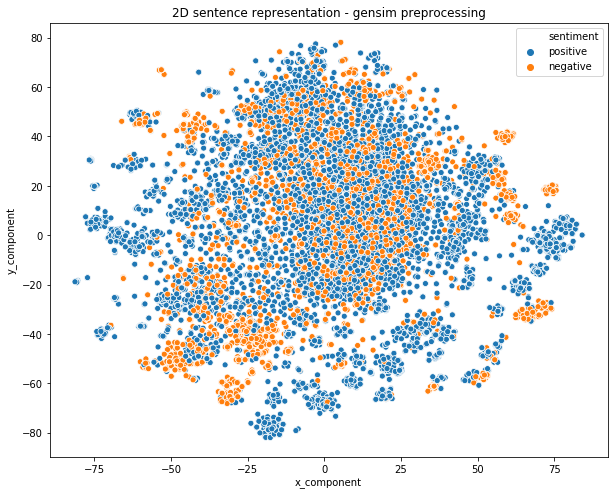

In [30]:
X_2d_financial = tsne.fit_transform(X_train_pre_w2v[0:10000])
X_component_financial = [item[0] for item in X_2d_financial]
Y_component_financial = [item[1] for item in X_2d_financial]
df_scatter_financial = pd.DataFrame({'x_component':X_component_financial, 'y_component':Y_component_financial, 'sentiment':sent})
plt.figure(figsize=(10,8))
plt.title("2D sentence representation - gensim preprocessing")
ax = sns.scatterplot(x='x_component', y='y_component', hue='sentiment', data=df_scatter_financial)

# 12. Classificateur

In [2]:
classfication_data = pd.read_csv('dataset/market_dataset/market.csv')

## 12.1 Prétraitement des données
On enlève les phrases avec un sentiment compris entre -0.3 et 0.3

In [3]:
print("size before : {}".format(len(classfication_data)))
index_to_remove = []
for i, e in classfication_data.iterrows():
    if e['sentiment'] < 0.3 and e['sentiment'] > -0.3:
        index_to_remove.append(i)


size before : 1225718


In [4]:
classfication_data = classfication_data.drop(index_to_remove)
print("size after : {}".format(len(classfication_data)))

size after : 540779


In [5]:
classfication_data = classfication_data[0:30000]

## 12.2 Séparation des données
le sentiment est défini à 0 pour une phrase négative et 1 pour une phrase positive

In [6]:
X_classification = classfication_data['title']
y_classfication = np.array([1 if s > 0 else 0 for s in classfication_data['sentiment']])
X_train_classification, X_test_classification, y_train_classfication, y_test_classification = train_test_split(X_classification, y_classfication, test_size=0.30, random_state=42)

## 12.3 Prétraitement du texte

In [7]:
X_train_pre_gen_classification = [' '.join(simple_preprocess(sentence)) for sentence in X_train_classification]
X_test_pre_gen_classification = [' '.join(simple_preprocess(sentence)) for sentence in X_test_classification ]

## 12.4 Entrainement des modèles

In [8]:
nb_model = Pipeline([('tfidf', TfidfVectorizer()),
                    ('nb', MultinomialNB())])

svc_model = Pipeline([('tfidf', TfidfVectorizer()),
                     ('svc', LinearSVC())])

dtc_model = Pipeline([('tfidf', TfidfVectorizer()),
                     ('dtc', DecisionTreeClassifier())])

logr_model = Pipeline([('tfidf', TfidfVectorizer()),
                    ('lr', LogisticRegression())])

nb_model.fit(X_train_pre_gen_classification, y_train_classfication)
svc_model.fit(X_train_pre_gen_classification, y_train_classfication)
dtc_model.fit(X_train_pre_gen_classification, y_train_classfication)
logr_model.fit(X_train_pre_gen_classification, y_train_classfication)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

## 12.5 Calcul des scores
On constate que le modèle SVC et Regression Logistic obtient d'excellent résultats

In [9]:
y_pred_nb = nb_model.predict(X_test_pre_gen_classification)
print("Accuracy for Naive Bayes : {}".format(metrics.accuracy_score(y_test_classification, y_pred_nb)))
print("Recall for Naive Bayes : {}".format(metrics.recall_score(y_test_classification, y_pred_nb)))
print("Precision for Naive Bayes : {}".format(metrics.precision_score(y_test_classification, y_pred_nb)))
print("\n")

y_pred_svc = svc_model.predict(X_test_pre_gen_classification)
print("Accuracy for SVC : {}".format(metrics.accuracy_score(y_test_classification, y_pred_svc)))
print("Recall for SVC : {}".format(metrics.recall_score(y_test_classification, y_pred_svc)))
print("Precision for SVC : {}".format(metrics.precision_score(y_test_classification, y_pred_svc)))
print("\n")

y_pred_dtc = dtc_model.predict(X_test_pre_gen_classification)
print("Accuracy for Decision Tree Classifier : {}".format(metrics.accuracy_score(y_test_classification, y_pred_dtc)))
print("Recall for Decision Tree Classifier : {}".format(metrics.recall_score(y_test_classification, y_pred_dtc)))
print("Precision for Decision Tree Classifier : {}".format(metrics.precision_score(y_test_classification, y_pred_dtc)))
print("\n")

y_pred_logr = logr_model.predict(X_test_pre_gen_classification)
print("Accuracy for Logistic Regression : {}".format(metrics.accuracy_score(y_test_classification, y_pred_logr)))
print("Recall for Logistic Regression : {}".format(metrics.recall_score(y_test_classification, y_pred_logr)))
print("Precision for Logistic Regression : {}".format(metrics.precision_score(y_test_classification, y_pred_logr)))
print("\n")

Accuracy for Naive Bayes : 0.9071111111111111
Recall for Naive Bayes : 0.9655940093098563
Precision for Naive Bayes : 0.877505977561155


Accuracy for SVC : 0.9608888888888889
Recall for SVC : 0.9757134183363692
Precision for SVC : 0.9540866811794974


Accuracy for Decision Tree Classifier : 0.893
Recall for Decision Tree Classifier : 0.9139850232746407
Precision for Decision Tree Classifier : 0.8935496636327661


Accuracy for Logistic Regression : 0.9371111111111111
Recall for Logistic Regression : 0.9694393847399312
Precision for Logistic Regression : 0.920268972142171




## 12.6 Entrainement du modèle par validation croisée

In [10]:
scores = cross_val_score(svc_model, X_train_pre_gen_classification, y_train_classfication, scoring="accuracy", cv=10, n_jobs=-1)
print(scores)

[0.95428571 0.96047619 0.96190476 0.95619048 0.96       0.96
 0.95666667 0.95904762 0.95666667 0.96952381]


# 13. Calcul des scores sur des headlines

## 13.1 Prétraitement

In [28]:
headlines = pd.read_json('dataset/headlines_dataset/financialData.json')

In [29]:
X_test_headlines = headlines['title']
y_test_headlines = np.array([1 if s > 0 else 0 for s in headlines['sentiment']])

In [30]:
X_test_pre_gen_headlines = [' '.join(simple_preprocess(sentence)) for sentence in X_test_headlines]

## 13.2 Calcul les scores
On constate malheurusement que avec les headlines les résultats obtenus sont très mauvais...

In [53]:
y_pred_svc_headlines = svc_model.predict(X_test_headlines)
print("Accuracy for SVC : {}".format(metrics.accuracy_score(y_test_headlines, y_pred_svc_headlines)))
print("Recall for SVC : {}".format(metrics.recall_score(y_test_headlines, y_pred_svc_headlines)))
print("Precision for SVC : {}".format(metrics.precision_score(y_test_headlines, y_pred_svc_headlines)))

Accuracy for SVC : 0.6161898115840894
Recall for SVC : 0.6321184510250569
Precision for SVC : 0.7097186700767263


In [48]:
y_test_regr_headlines =  headlines['sentiment']

In [51]:
y_pred_svr_headlines = svr_model.predict(X_test_pre_gen_headlines)
print_scores("SVR",y_pred_svr_headlines, y_test_regr_headlines)

RMSE for SVR : 0.6837469527642147
MAE for SVR : 0.5295670545998282
Accuracy for SVR : 0.6062120671188861
Recall for SVR : 0.7065148640101202
Precision for SVR : 0.6361047835990888


In [54]:
X_test_regr_w2v = sentences_to_w2v_small_vector(X_test_pre_gen_headlines, mode="avg")

y_pred_rfr_headlines = rfr_model_w2v.predict(X_test_regr_w2v)
print_scores("Random Forest Regressor", y_pred_rfr_headlines, y_test_regr_headlines)

RMSE for Random Forest Regressor : 0.46984117584254675
MAE for Random Forest Regressor : 0.37936727848580737
Accuracy for Random Forest Regressor : 0.5653606737458806
Recall for Random Forest Regressor : 0.6577992744860943
Precision for Random Forest Regressor : 0.63662960795787


# Conclusion
On constate donc que le modèle effectue de mauvaise prédiction sur le jeu de données des headlines financières. Ces modèles sont donc à abandonner. Pour plus d'information merci de consulter le rapport.